In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
## Model params
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
print(device)
n_embd=32 #size of embedding dimension
batch_size=64
block_size=8
lr=1e-3
eval_iters=10000

cuda:0


In [3]:
with open('input.txt',mode='r') as f:
    text=f.read()

In [4]:
len(text)

1115393

In [5]:
chars=sorted(list(set([x for x in text])))
vocab_size=len(chars)
print(' '.join(chars))
print(vocab_size)


   ! $ & ' , - . 3 : ; ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z
65


In [6]:
## Creating encoder and decoder functions simple value to int maps
## stoi maps char to int
## itos maps int to char
stoi={ch:i for i,ch in enumerate(chars)}
itoi={y:x for x,y in stoi.items()}
def encode(s):
    return [stoi[x] for x in s] #string to tokens
def decode(tok):
    return ''.join([itoi[x] for x in tok])#tokens to string

In [7]:
data=torch.tensor(encode(text),dtype=torch.long)
print(data.shape,data.dtype)
print(data[:100])

torch.Size([1115393]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [8]:
n=int(0.9*data.shape[0])
train_data=data[:n]
val_data=data[n:]

In [9]:
torch.manual_seed(1337)
def get_batch(split:str):
    data=train_data if split=='train' else val_data
    ix=torch.randint(low=0,high=len(data)-block_size-1,size=(batch_size,))
    x=torch.stack([data[i:i+block_size] for i in ix] )
    y=torch.stack([data[i+1:i+1+block_size] for i in ix] )
    return x,y

In [10]:
class Head(nn.Module):
    def __init__(self,head_size : int):
        super().__init__()
        self.head_size=head_size
        self.key=nn.Linear(n_embd,head_size,bias=False)
        self.query=nn.Linear(n_embd,head_size,bias=False)
        self.value=nn.Linear(n_embd,head_size,bias=False)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
    def forward(self,x):
        k=self.key(x) ## B*T*head_size
        q=self.query(x) ## B*T*head_size
        v=self.value(x) ## B*T*head_size
        wei=(q@k.transpose(-2,-1))*(self.head_size**-0.5) ## B*T*T
        wei=wei.masked_fill(self.tril==0,float("-inf"))
        wei=F.softmax(wei,dim=-1)
        out=wei@v ## B*T*head_size
        return out

In [11]:
class BigramModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table=nn.Embedding(vocab_size,n_embd) # We map to some embedding dimensions
        self.position_embedding_table=nn.Embedding(block_size,n_embd)
        self.sa_head=Head(n_embd)
        self.lm_head=nn.Linear(n_embd,vocab_size) #Going to logits from embedding 
        # We want this embed table to give the logits corresponding to prob of next charachter This is equivalent to predicting the next word using the last seen word only
    def forward(self,input,target=None):

        tok_emb=self.token_embedding_table(input)# gives a res of batch_size,block_size,n_embd(as this is the dimension of embed table)
        pos_emb=self.position_embedding_table(torch.arange(block_size,device=device)) # T*C
        x=tok_emb+pos_emb # B*T*C Brodcast along batch
        x=self.sa_head(x)
        logits=self.lm_head(x) # batch_size,block_size,vocab_size gives output probabilities  
        if target is None:
            loss=None
        else:
            logits=logits.view(batch_size*block_size,vocab_size)#Change shape for compatibility with cross_entropy
            target=target.view(batch_size*block_size)#Change shape for compatibility with cross_entropy
            loss=F.cross_entropy(logits,target)
        return logits,loss
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond=idx[:,-block_size:]## Atmost block size can be used due to positional encoding bound
            logits,_=self(idx_cond)
            logits=logits[:,-1,:] # B*C for each batch gives next prediction based on last word
            probs=F.softmax(logits,dim=1) #(B,C)
            idx_next=torch.multinomial(probs,num_samples=1)#(B,1) sample according to those probabilities
            idx=torch.cat((idx,idx_next),dim=1)# Attach those new words and last words and try again
        return idx
                        
            

# Model Train

In [12]:
m=BigramModel()
m.to(device)

BigramModel(
  (token_embedding_table): Embedding(65, 32)
  (position_embedding_table): Embedding(8, 32)
  (sa_head): Head(
    (key): Linear(in_features=32, out_features=32, bias=False)
    (query): Linear(in_features=32, out_features=32, bias=False)
    (value): Linear(in_features=32, out_features=32, bias=False)
  )
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)

In [13]:
print(m)

BigramModel(
  (token_embedding_table): Embedding(65, 32)
  (position_embedding_table): Embedding(8, 32)
  (sa_head): Head(
    (key): Linear(in_features=32, out_features=32, bias=False)
    (query): Linear(in_features=32, out_features=32, bias=False)
    (value): Linear(in_features=32, out_features=32, bias=False)
  )
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)


In [14]:
optimizer=torch.optim.AdamW(m.parameters(),lr=lr)

In [15]:
losses=[]
for _ in range(eval_iters):
    xb,yb=get_batch("train")
    xb=xb.to(device)
    yb=yb.to(device)
    logits,loss=m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()    
    losses.append(loss.item())


Text(0, 0.5, 'Loss')

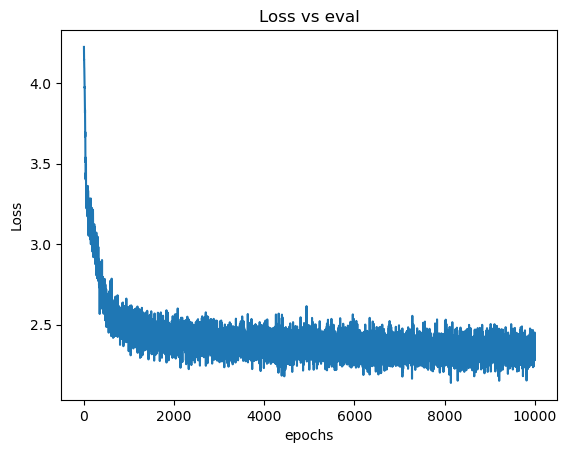

In [26]:
plt.plot([x for x in range(1,eval_iters+1)],losses)
plt.title("Loss vs eval")
plt.xlabel("epochs")
plt.ylabel("Loss")